<a href="https://colab.research.google.com/github/Inaracrewc/Birds/blob/main/Crop_bird_into_4_pcs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 5.9MB/s 
     |████████████████████████████████| 194kB 29.7MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 1.2MB 19.9MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = '/content/gdrive/MyDrive/BIRDS/'
base_dir = root_dir + 'train'

In [5]:
import PIL
import torch
import pathlib
import numpy as np
from fastai import *
from fastai.vision.all import *

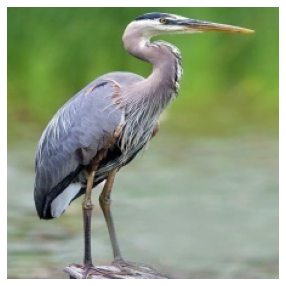

In [6]:
img = PILImage.create('/content/gdrive/MyDrive/BIRDS/blue heron 018.jpg')
img.show();

In [7]:
img.shape

(224, 224)

In [8]:
rows, columns = img.shape

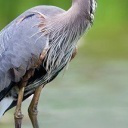

In [73]:
c_crop = img.crop_pad(128) # for center crop TTA
c_crop

In [74]:
c_crop.shape

(128, 128)

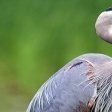

In [108]:
#Upper left corner
ul_crop = img.crop((0,0,112,112)) #left, up, right, bottom
ul_crop

In [109]:
ul_crop.shape

(112, 112)

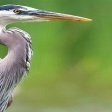

In [110]:
#Upper right corner
ur_crop = img.crop((112, 0, 224, 112)) # 4-tuple defining the left, upper, right, and lower pixel coordinate
ur_crop

In [111]:
ur_crop.shape

(112, 112)

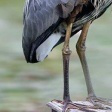

In [114]:
#Lower left corner
ll_crop = img.crop((0, 112, 112, 224))
ll_crop

In [113]:
ll_crop.shape

(112, 128)

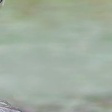

In [115]:
#Lower right crop
lr_crop = img.crop((112, 112, 224, 224))
lr_crop

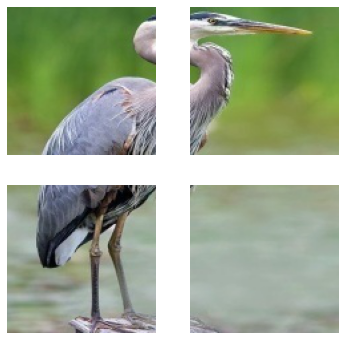

In [117]:
#Combine and display corner crops
corner_crops = [ul_crop, ur_crop, ll_crop, lr_crop]
fig, axs = plt.subplots(2,2, figsize=(6,6))

for o, ax in zip(corner_crops, axs.flatten()):
    show_image(o, ax)

In [118]:
Define generic function to extract crops for any image

In [119]:
def crops_tta(img, size):
    h, w = img.shape
    c = img.crop_pad(size)
    ul = img.crop((0, 0, 0+size, 0+size))
    ur = img.crop((w-size, 0, w, size))
    ll = img.crop((0, h-size, size, h))
    lr = img.crop((w-size, h-size, w, h))
    return c, ul, ur, ll, lr

In [120]:
crops = crops_tta(img, 112)

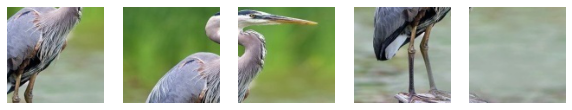

In [121]:
#check if the same images were returned
fig, axs = plt.subplots(1,5, figsize=(10,10))

for o, ax in zip(crops, axs.flatten()):
    show_image(o, ax)

In [161]:
learn = load_learner("/content/gdrive/MyDrive/BIRDS/birds.pkl")

In [ ]:
#Define the four corner crops as transforms
#coz img are not PIL anymore, use indexing instead of the crop function to create the crops

In [128]:
class UpperLeft(Transform):
    def __init__(self, size):
        self.size = size
    
    def encodes(self, img:TensorImage):
        _, _, h, w = img.shape
        return img[..., :self.size, :self.size]

In [129]:
class UpperRight(Transform):
    def __init__(self, size):
        self.size = size
    
    def encodes(self, img:TensorImage):
        _, _, h, w = img.shape
        return img[..., :self.size, w-self.size:]

In [130]:
class LowerLeft(Transform):
    def __init__(self, size):
        self.size = size
    
    def encodes(self, img:TensorImage):
        _, _, h, w = img.shape
        return img[..., h-self.size:, :self.size]

In [131]:
class LowerRight(Transform):
    def __init__(self, size):
        self.size = size
    
    def encodes(self, img:TensorImage):
        _, _, h, w = img.shape
        return img[..., h-self.size:, w-self.size:]

In [159]:
path = '/content/gdrive/MyDrive/BIRDS/'

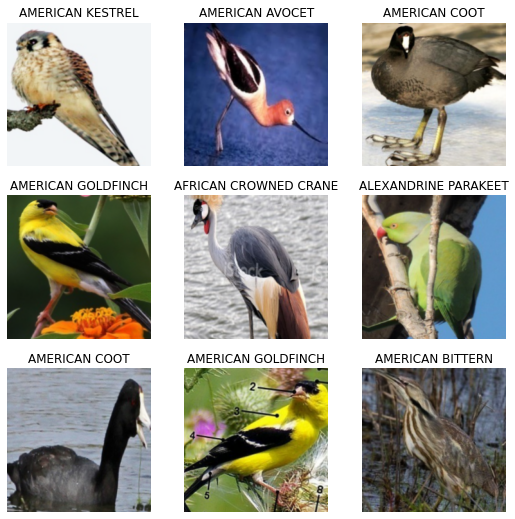

In [160]:
dls = ImageDataLoaders.from_folder(path,
                 item_tfms=Resize(340),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75), bs=64)
dls.show_batch(nrows=3, ncols=3)

In [164]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=[aug_transforms(size=224, min_scale=0.75),
                   Normalize.from_stats(*imagenet_stats)]) 

In [165]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.429710,0.012650,0.000000,08:17


epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: ignored

In [166]:
learn.dls.train.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> RandomResizedCropGPU -- {'size': (224, 224), 'min_scale': 0.75, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}

In [167]:
learn.dls.valid.after_batch # converts images to Tensor

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> RandomResizedCropGPU -- {'size': (224, 224), 'min_scale': 0.75, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}

In [168]:
def tta_cc(learn, dl, size):
    tfms = [UpperLeft(size), UpperRight(size), LowerLeft(size), LowerRight(size)]
    tta_preds = []
    # get predictions for default approach on validation sets that uses the center crop
    preds, targs = learn.get_preds()
    tta_preds.append(preds[None])
    # get predictions using each of the four corner crops
    for tfm in tfms:
        dl = dl.new(after_batch=Pipeline([IntToFloatTensor, tfm]))
        tta_preds.append(learn.get_preds(dl=dl, inner=True)[0][None])
    
    tta_preds = torch.cat(tta_preds).mean(0)
    return tta_preds, targs
    

In [169]:
preds, targs = tta_cc(learn, learn.dls.valid, 112)

epoch,train_loss,valid_loss,error_rate,time


In [170]:
accuracy(preds, targs)

TensorBase(0.8000)

In [171]:
#compare with accuracy of the default fastai implementation - center crop
preds, targs = learn.tta(dl=learn.dls.valid)

In [172]:
accuracy(preds, targs)

TensorBase(1.)

In [ ]:
###credits for posting a very good explanation how to perform comparing TTA testing to https://github.com/asiedubrempong

In [174]:
learn.path = Path("/content/gdrive/MyDrive/BIRDS")
learn.export('birdstta.pkl')